In [1]:
!pip install datasets
!pip install transformers
!pip install numpy
!pip install torch
!pip install matplotlib
!pip install seaborn
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import datasets
from datasets import Dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoTokenizer

import numpy as np
import torch
import matplotlib.pyplot as plt
import gc
import random
import seaborn as sns
import pandas as pd

CACHE_DIR = "./cache"

In [3]:
## DATASET CODE ##
def load_mnli_datasets() -> DatasetDict:
    print("\nLoading MNLI Dataset")
    mnli: DatasetDict = datasets.load_dataset("glue", "mnli", cache_dir=CACHE_DIR)  # type: ignore
    # Filter neutral examples for binary classification
    mnli = mnli.filter(lambda x: x["label"] != 1)

    # MNLI entailment is 0, contradiction is 2; update labels so that entailment is 1 and contradiction is 0
    def change_label(example):
        if example["label"] == 0:
            example["label"] = 1
        else:
            example["label"] = 0
        return example

    mnli = mnli.map(change_label)
    del mnli["test_matched"]
    del mnli["test_mismatched"]
    del mnli["validation_mismatched"]

    print("MNLI Datasets:")
    print(mnli)

    return mnli


def load_hans_dataset() -> Dataset:
    hans: Dataset = datasets.load_dataset("hans", cache_dir=CACHE_DIR, split="validation", trust_remote_code=True)  # type: ignore

    # HANS comes without indices, so we add them
    indices = list(range(len(hans)))
    hans = hans.add_column(name="idx", column=indices)

    # Filter for lexical overlap
    hans = hans.filter(lambda x: x["heuristic"] == "lexical_overlap")

    hans = hans.select_columns(["premise", "hypothesis", "label", "idx"])

    print("HANS Dataset:")
    print(hans)

    return hans

In [4]:
## IN-CONTEXT LEARNING CODE ##
def create_few_shot_context(train_examples, context_indices):
    context = ""
    for idx in context_indices:
        example = train_examples[int(idx)]
        label_text = "True" if example["label"] == 1 else "False"
        context += f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer: {label_text}\n\n"

    return context

In [5]:
## CONTEXT DISTILLATION CODE ##
def compute_kl_divergence(teacher_logits, student_logits):
    teacher_probs = torch.softmax(teacher_logits, dim=-1)
    student_probs = torch.softmax(student_logits, dim=-1)
    return torch.nn.functional.kl_div(
        torch.log(student_probs),
        teacher_probs,
        reduction="batchmean",
        log_target=False
    )


def get_teacher_logits(
    teacher_model, tokenizer, train_dataset, context, example_indices
):
    device = teacher_model.device
    all_teacher_logits = []

    for idx in example_indices:
        example = train_dataset[int(idx)]
        teacher_prompt = (
            context
            + f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"
        )

        teacher_inputs = tokenizer(teacher_prompt, return_tensors="pt", padding=True)
        teacher_inputs = {k: v.to(device) for k, v in teacher_inputs.items()}

        with torch.no_grad():
            teacher_outputs = teacher_model(**teacher_inputs)
            teacher_logits = teacher_outputs.logits[0, -1]

        all_teacher_logits.append(teacher_logits.detach().clone())

    return all_teacher_logits


def train_student_model(
    student_model,
    tokenizer,
    train_dataset,
    example_indices,
    teacher_logits_list,
    num_epochs,
    learning_rate,
):
    device = student_model.device
    optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
    )

    # Add gradient clipping
    max_grad_norm = 1.0

    print("Training student model...")
    for epoch in range(num_epochs):
        total_loss = 0

        student_model.train()
        for _, (idx, teacher_logits) in enumerate(
            zip(example_indices, teacher_logits_list)
        ):
            optimizer.zero_grad()

            example = train_dataset[int(idx)]
            student_prompt = f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"

            student_inputs = tokenizer(
                student_prompt, return_tensors="pt", padding=True
            )
            student_inputs = {k: v.to(device) for k, v in student_inputs.items()}
            student_outputs = student_model(**student_inputs)
            student_logits = student_outputs.logits[:, -1, :]

            loss = compute_kl_divergence(teacher_logits, student_logits)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_grad_norm)

            optimizer.step()

            del student_outputs, student_inputs, student_logits
            torch.cuda.empty_cache()
            gc.collect()

            total_loss += loss.item()

        avg_loss = total_loss / len(example_indices)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

In [6]:
## EVALUATION CODE ##
def evaluate_icl(model, tokenizer, eval_dataset, context, eval_indices):
    device = model.device
    correct = 0
    total = 0
    labels = []

    target_tokens = [" False", " True"]
    target_token_ids = [
        tokenizer.encode(token, add_special_tokens=False)[0] for token in target_tokens
    ]

    for idx in eval_indices:
        example = eval_dataset[int(idx)]
        prompt = (
            context
            + f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"
        )

        inputs = tokenizer(prompt, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1]

        target_probs = logits[target_token_ids]
        predicted_label = torch.argmax(target_probs).item()
        labels.append(predicted_label)

        if predicted_label == example["label"]:
            correct += 1
        total += 1

    label, counts = np.unique(np.array(labels), return_counts=True)
    print(f"Prediction distribution:\tLabels: {label}, Count: {counts}")
    accuracy = correct / total
    return accuracy


def evaluate_cd(model, tokenizer, eval_dataset, eval_indices):
    device = model.device
    correct = 0
    total = 0
    labels = []

    target_tokens = [" False", " True"]
    target_token_ids = [
        tokenizer.encode(token, add_special_tokens=False)[0] for token in target_tokens
    ]

    for idx in eval_indices:
        example = eval_dataset[int(idx)]
        prompt = f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"

        inputs = tokenizer(prompt, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1]

        target_probs = logits[target_token_ids]
        predicted_label = torch.argmax(target_probs).item()
        labels.append(predicted_label)

        if predicted_label == example["label"]:
            correct += 1
        total += 1

    label, counts = np.unique(np.array(labels), return_counts=True)
    print(f"Prediction distribution:\tLabels: {label}, Count: {counts}")
    accuracy = correct / total
    return accuracy

In [7]:
def eval(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    models = [
        "facebook/opt-125m",
        "facebook/opt-350m",
        "facebook/opt-1.3b",
    ]

    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    mnli = load_mnli_datasets()
    training = mnli["train"]
    validation_in_domain = mnli["validation_matched"]
    validation_out_domain = load_hans_dataset()

    # ICL parameters
    num_shots = 10
    # Context distillation parameters
    num_train_examples = 20
    num_epochs = 10
    learning_rate = 1e-6
    # Validation parameters
    num_validation_samples = 100

    # Get a set of balanced indices for the ICL context
    true_examples = [i for i in range(len(training)) if training[i]["label"] == 1]
    false_examples = [i for i in range(len(training)) if training[i]["label"] == 0]
    num_per_class = num_shots // 2
    context_indices = np.concatenate([
        np.random.choice(true_examples, size=num_per_class, replace=False),
        np.random.choice(false_examples, size=num_per_class, replace=False)
    ])
    np.random.shuffle(context_indices)

    validation_in_domain_indices = np.random.choice(
        len(validation_in_domain), num_validation_samples, replace=False
    )
    validation_out_domain_indices = np.random.choice(
        len(validation_out_domain), num_validation_samples, replace=False
    )

    # Avoid using the same examples for the context and context distillation training
    available_true = [i for i in true_examples if i not in context_indices]
    available_false = [i for i in false_examples if i not in context_indices]
    # Get a set of balanced indices for context distillation
    num_per_class_train = num_train_examples // 2
    train_indices = np.concatenate([
        np.random.choice(available_true, size=num_per_class_train, replace=False),
        np.random.choice(available_false, size=num_per_class_train, replace=False)
    ])
    np.random.shuffle(train_indices)

    context = create_few_shot_context(training, context_indices=context_indices)

    results = {}

    for model_name in models:
        print(f"\nEvaluating {model_name}")

        teacher_model = AutoModelForCausalLM.from_pretrained(model_name)
        teacher_model = teacher_model.to(device)
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        print("\nIn-Context Learning Evaluation:")
        icl_in_domain = evaluate_icl(
            model=teacher_model,
            tokenizer=tokenizer,
            eval_dataset=validation_in_domain,
            context=context,
            eval_indices=validation_in_domain_indices,
        )
        icl_out_domain = evaluate_icl(
            model=teacher_model,
            tokenizer=tokenizer,
            eval_dataset=validation_out_domain,
            context=context,
            eval_indices=validation_out_domain_indices,
        )
        print(f"ICL In-Domain: {icl_in_domain}")
        print(f"ICL Out-Domain: {icl_out_domain}")

        print("\nTraining student model with Context Distillation:")
        # Get teacher logits before training student
        print("Computing teacher logits...")
        teacher_logits_list = get_teacher_logits(
            teacher_model, tokenizer, training, context, train_indices
        )

        teacher_model = teacher_model.cpu()
        del teacher_model
        torch.cuda.empty_cache()
        gc.collect()

        student_model = AutoModelForCausalLM.from_pretrained(model_name)
        student_model = student_model.to(device)

        train_student_model(
            student_model=student_model,
            tokenizer=tokenizer,
            train_dataset=training,
            example_indices=train_indices,
            teacher_logits_list=teacher_logits_list,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
        )

        print("\nContext Distillation Evaluation:")
        cd_in_domain = evaluate_cd(
            model=student_model,
            tokenizer=tokenizer,
            eval_dataset=validation_in_domain,
            eval_indices=validation_in_domain_indices,
        )

        cd_out_domain = evaluate_cd(
            model=student_model,
            tokenizer=tokenizer,
            eval_dataset=validation_out_domain,
            eval_indices=validation_out_domain_indices,
        )
        print(f"CD In-Domain: {cd_in_domain}")
        print(f"CD Out-Domain: {cd_out_domain}")

        simple_model_name = model_name.split("/")[-1]
        results[simple_model_name] = {
            "icl_in_domain": icl_in_domain,
            "icl_out_domain": icl_out_domain,
            "cd_in_domain": cd_in_domain,
            "cd_out_domain": cd_out_domain,
        }

        student_model = student_model.cpu()
        del student_model
        torch.cuda.empty_cache()
        gc.collect()

    return results

In [8]:
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)


=== Running iteration 1/5 with seed 100 ===
Using device: cuda

Loading MNLI Dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

Map:   0%|          | 0/261802 [00:00<?, ? examples/s]

Map:   0%|          | 0/6692 [00:00<?, ? examples/s]

Map:   0%|          | 0/6703 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

MNLI Datasets:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 261802
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6692
    })
})


README.md:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

hans.py:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

HANS Dataset:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 10000
})

Evaluating facebook/opt-125m


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]


In-Context Learning Evaluation:
Prediction distribution:	Labels: [0 1], Count: [11 89]
Prediction distribution:	Labels: [1], Count: [100]
ICL In-Domain: 0.56
ICL Out-Domain: 0.57

Training student model with Context Distillation:
Computing teacher logits...
Training student model...
Epoch 1/10, Average Loss: 0.7896
Epoch 2/10, Average Loss: 0.1297
Epoch 3/10, Average Loss: 0.1324
Epoch 4/10, Average Loss: 0.1305
Epoch 5/10, Average Loss: 0.0855
Epoch 6/10, Average Loss: 0.0658
Epoch 7/10, Average Loss: 0.1143
Epoch 8/10, Average Loss: 0.1063
Epoch 9/10, Average Loss: 0.0665
Epoch 10/10, Average Loss: 0.0660

Context Distillation Evaluation:
Prediction distribution:	Labels: [0 1], Count: [23 77]
Prediction distribution:	Labels: [0 1], Count: [67 33]
CD In-Domain: 0.5
CD Out-Domain: 0.52

Evaluating facebook/opt-350m


config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]


In-Context Learning Evaluation:
Prediction distribution:	Labels: [0 1], Count: [ 5 95]
Prediction distribution:	Labels: [1], Count: [100]
ICL In-Domain: 0.56
ICL Out-Domain: 0.57

Training student model with Context Distillation:
Computing teacher logits...
Training student model...
Epoch 1/10, Average Loss: 0.4147
Epoch 2/10, Average Loss: 0.1310
Epoch 3/10, Average Loss: 0.1293
Epoch 4/10, Average Loss: 0.1410
Epoch 5/10, Average Loss: 0.0877
Epoch 6/10, Average Loss: 0.0446
Epoch 7/10, Average Loss: 0.0655
Epoch 8/10, Average Loss: 0.0621
Epoch 9/10, Average Loss: 0.0518
Epoch 10/10, Average Loss: 0.0411

Context Distillation Evaluation:
Prediction distribution:	Labels: [0 1], Count: [21 79]
Prediction distribution:	Labels: [0 1], Count: [ 4 96]
CD In-Domain: 0.56
CD Out-Domain: 0.57

Evaluating facebook/opt-1.3b


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]


In-Context Learning Evaluation:
Prediction distribution:	Labels: [0 1], Count: [99  1]
Prediction distribution:	Labels: [0], Count: [100]
ICL In-Domain: 0.44
ICL Out-Domain: 0.43

Training student model with Context Distillation:
Computing teacher logits...
Training student model...
Epoch 1/10, Average Loss: 0.2562
Epoch 2/10, Average Loss: 0.1505
Epoch 3/10, Average Loss: 0.1093
Epoch 4/10, Average Loss: 0.1569
Epoch 5/10, Average Loss: 0.0764
Epoch 6/10, Average Loss: 0.0783
Epoch 7/10, Average Loss: 0.0890
Epoch 8/10, Average Loss: 0.1205
Epoch 9/10, Average Loss: 0.0458
Epoch 10/10, Average Loss: 0.0195

Context Distillation Evaluation:
Prediction distribution:	Labels: [0], Count: [100]
Prediction distribution:	Labels: [0], Count: [100]
CD In-Domain: 0.43
CD Out-Domain: 0.43

=== Running iteration 2/5 with seed 101 ===
Using device: cuda

Loading MNLI Dataset
MNLI Datasets:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_

<ipython-input-9-07fec3fbd5ee>:24: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


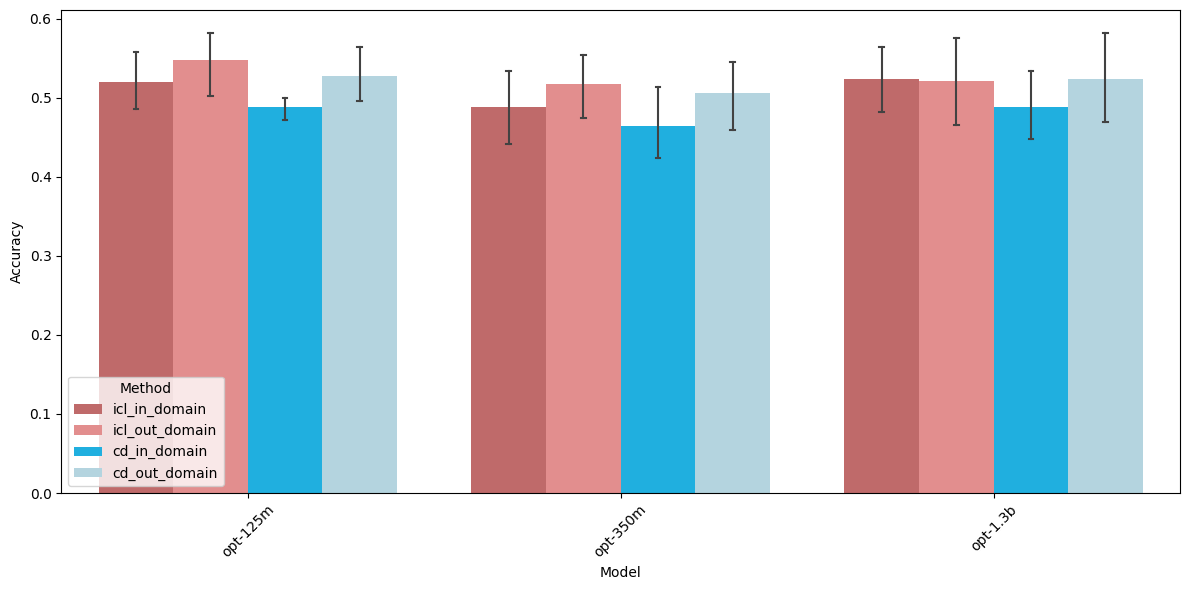

In [9]:
plt.figure(figsize=(12, 6))

colors = {
    'icl_in_domain': 'indianred',
    'icl_out_domain': 'lightcoral',
    'cd_in_domain': 'deepskyblue',
    'cd_out_domain': 'lightblue'
}

models = list(all_results.keys())
metrics = ['icl_in_domain', 'icl_out_domain', 'cd_in_domain', 'cd_out_domain']

data = []
for model in models:
    for metric in metrics:
        data.extend([{
            'Model': model,
            'Method': metric,
            'Accuracy': value
        } for value in all_results[model][metric]])

df = pd.DataFrame(data)

sns.barplot(
    data=df,
    x='Model',
    y='Accuracy',
    hue='Method',
    palette=colors,
    capsize=0.05,
    errwidth=1.5
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")


opt-125m:
  icl_in_domain: 0.520 ± 0.041
  icl_out_domain: 0.548 ± 0.047
  cd_in_domain: 0.488 ± 0.016
  cd_out_domain: 0.528 ± 0.041

opt-350m:
  icl_in_domain: 0.488 ± 0.052
  icl_out_domain: 0.518 ± 0.048
  cd_in_domain: 0.464 ± 0.053
  cd_out_domain: 0.506 ± 0.049

opt-1.3b:
  icl_in_domain: 0.524 ± 0.051
  icl_out_domain: 0.522 ± 0.063
  cd_in_domain: 0.488 ± 0.049
  cd_out_domain: 0.524 ± 0.069
